In [222]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn as skl
import sklearn.model_selection
import sklearn.kernel_ridge

## preprocessing the data

In [223]:
# import data
train_data = pd.read_csv("wine_training.csv",header=None)
test_data = pd.read_csv("wine_test.csv",header = None)
new_data = pd.read_csv("wine_new_batch.csv",header = None)

# normalize the training features
X_train = np.array(train_data)[:,0:11]

X_train_N = X_train.shape[0]# number of rows

X_train_mean = np.mean(X_train,axis = 0)
X_train_std = np.std(X_train,axis = 0)

X_train_normal = (X_train - X_train_mean)/X_train_std
#X_train_normal = (X_train - np.matlib.repmat(X_train_mean, X_train_N, 1))/np.matlib.repmat(X_train_std, X_train_N, 1)

# normalize the training labels
Y_train = np.array(train_data)[:,11]

Y_train_mean = np.mean(Y_train,axis = 0)
Y_train_std = np.std(Y_train,axis = 0)

Y_train_normal = (Y_train - Y_train_mean)/Y_train_std

# normalize the testing data using training mean and std

X_test = np.array(test_data)[:,0:11]
Y_test = np.array(test_data)[:,11]
X_test_N = X_test.shape[0]


X_test_normal = (X_test - X_train_mean)/X_train_std
#X_test_normal = (X_test - np.matlib.repmat(X_train_mean, X_test_N, 1))/np.matlib.repmat(X_train_std, X_test_N, 1)
Y_test_normal = (Y_test - Y_train_mean)/Y_train_std

## normalize the new batch
new_data = np.array(new_data)
new_data_N = new_data.shape[0]

new_data_normal = (new_data - np.matlib.repmat(X_train_mean,new_data_N,1))/np.matlib.repmat(X_train_std,new_data_N,1)

## CV for hyperparameter tuning

### CV for RBF kernel hyperparameter tuning

We first start with a wide range with a few steps

log_2 sg: 1.666666666666667 log_2_lmbd:  -1.6666666666666665


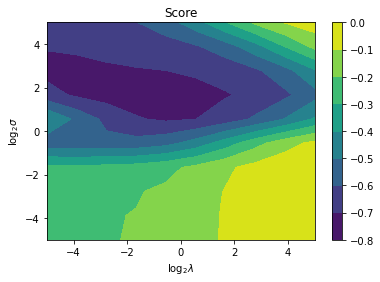

In [302]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-5,5],lmbd_range = [-5,5],kernel_type = "rbf")

log_2 sg: 1.666666666666666 log_2_lmbd:  -1.6666666666666667


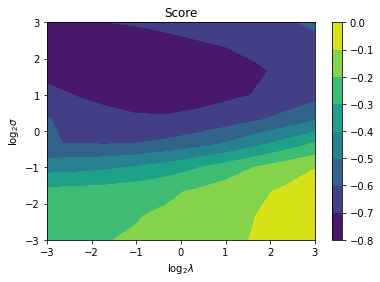

In [315]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-3,3],lmbd_range = [-3,3],kernel_type = "rbf")

log_2 sg: 1.5555555555555554 log_2_lmbd:  -1.5555555555555556


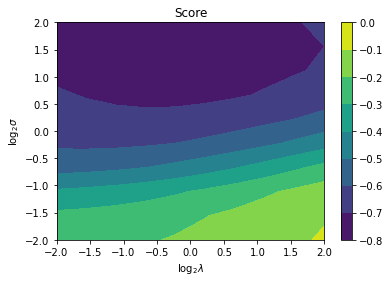

In [333]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-2,2],lmbd_range = [-2,2],kernel_type = "rbf")

### CV for Laplacian kernel hyperparameter

log_2 sg: 0.5555555555555554 log_2_lmbd:  -1.6666666666666665


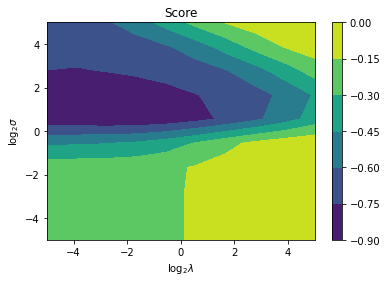

In [337]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-5,5],lmbd_range = [-5,5],kernel_type = "laplacian")

log_2 sg: 0.6666666666666665 log_2_lmbd:  -2.0


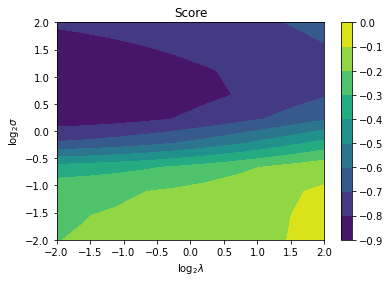

In [349]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-2,2],lmbd_range = [-2,2],kernel_type = "laplacian")

log_2 sg: 0.5555555555555554 log_2_lmbd:  -2.0


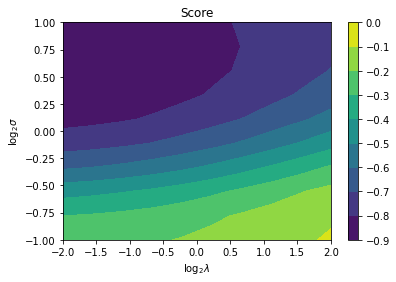

In [351]:
sig,lmbd = refine_search(K_sgm = 10,K_lmbd = 10,sgm_range = [-1,1],lmbd_range = [-2,2],kernel_type = "laplacian")

## Fit the model with the best hyper parameter

### fit linear regression

In [355]:
linear_model = LinearRegression().fit(X_train_normal, Y_train_normal)

Y_train_predict = linear_model.predict(X_train_normal)
Y_test_predict = linear_model.predict(X_test_normal)

print("train mse: ",mean_squared_error(Y_train_normal,Y_train_predict))
print("test mse: ",mean_squared_error(Y_test_normal,Y_test_predict))

train mse:  0.6278484956554883
test mse:  0.7471696905187208


### fit RBF ridge

In [354]:
# optimal value found by CV
lbd = 2**(-1.5555556)
sig = 2**(1.5555554)
KRR1 = skl.kernel_ridge.KernelRidge(kernel='rbf', alpha = lbd, gamma=1/(2*sig**2))

KRR1.fit(X_train_normal, Y_train_normal)

Y_train_predict = KRR1.predict(X_train_normal)
Y_test_predict = KRR1.predict(X_test_normal)

print("train mse: ",mean_squared_error(Y_train_normal,Y_train_predict))
print("test mse: ",mean_squared_error(Y_test_normal,Y_test_predict))

train mse:  0.4309297474858547
test mse:  0.6674829566575938


### fit Laplacian ridge

In [353]:
lbd = 2**(-2)
sig = 2**(0.55555555555554)
KRR2 = skl.kernel_ridge.KernelRidge(kernel='laplacian', alpha = lbd, gamma=1/(2*sig**2))

KRR2.fit(X_train_normal, Y_train_normal)

Y_train_predict = KRR2.predict(X_train_normal)
Y_test_predict = KRR2.predict(X_test_normal)

print("train mse: ",mean_squared_error(Y_train_normal,Y_train_predict))
print("test mse: ",mean_squared_error(Y_test_normal,Y_test_predict))

train mse:  0.06350755969047356
test mse:  0.607592529296763


## predict the new batch

### predict with linear regression

In [361]:
pre = linear_model.predict(new_data_normal)
np.round(pre*Y_train_std+Y_train_mean)

array([6., 5., 6., 6., 6.])

### predict with RBF kernel ridge

In [362]:
pre = KRR1.predict(new_data_normal)
np.round(pre*Y_train_std+Y_train_mean)

array([6., 5., 5., 6., 6.])

### predict with laplacian kernel ridge

In [363]:
pre = KRR2.predict(new_data_normal)
np.round(pre*Y_train_std+Y_train_mean)

array([6., 5., 6., 6., 6.])

## helper function

In [296]:
# @ params: K_sgm, K_lmbd: step size of the range
# @ params: sgm_range: vector of form [a,b]; same for lmbd_range

def refine_search(K_sgm,K_lmbd,sgm_range,lmbd_range,kernel_type):
    
    sgm = np.linspace(sgm_range[0], sgm_range[1], K_sgm)
    lmbd = np.linspace(lmbd_range[0], lmbd_range[1], K_lmbd)

    scores = np.zeros((K_sgm, K_lmbd))
    scores_std = np.zeros((K_sgm, K_lmbd))

    KRR_CV = skl.kernel_ridge.KernelRidge(kernel= kernel_type)

    for i in range(K_sgm):

        KRR_CV.gamma = 1/(2*(2**sgm[i])**2)

        for j in range(K_lmbd):

            KRR_CV.alpha = (2**lmbd[j])
            this_score = skl.model_selection.cross_val_score(KRR_CV, X_train_normal, Y_train_normal, scoring= 'neg_mean_squared_error', cv=10)

            scores[i,j] = (np.mean(this_score))
            scores_std[i,j] = (np.std(this_score))
        

    lv, sv = np.meshgrid(lmbd, sgm)

    #fig, ax = plt.subplots(1,2, figsize=(20,10))

    plt.contourf( lv, sv, np.log2(np.abs(scores)))
    plt.xlabel('$\log_2\lambda$')
    plt.ylabel('$\log_2\sigma$')
    plt.title('Score')
    plt.colorbar()


    fig.tight_layout()
    
    ij_max = np.array( np.where( scores == scores.max() ), dtype=int).flatten()
    print('log_2 sg:', sgm[ij_max[0]], 'log_2_lmbd: ', lmbd[ij_max[1]])
    return sgm[ij_max[0]],lmbd[ij_max[1]]